## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [12]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')
img_size = cv2.imread(images[0]).shape[0:2]
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
#         img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#         cv2.imshow('',img)
#         cv2.waitKey(500)

# cv2.destroyAllWindows()

retval, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

## Demo the undistorted image

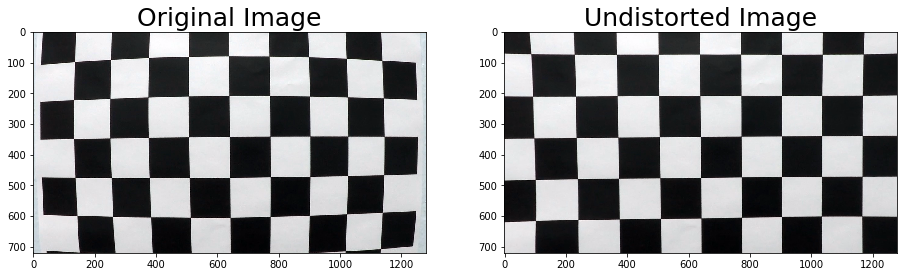

In [21]:
undistort_src = cv2.imread(images[0])
undistort_dst = cv2.undistort(undistort_src, cameraMatrix, distCoeffs, None, cameraMatrix)
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
ax1.imshow(undistort_src)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(undistort_dst)
ax2.set_title('Undistorted Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('undistortion_demo_peng.png')

ValueError: left cannot be >= right

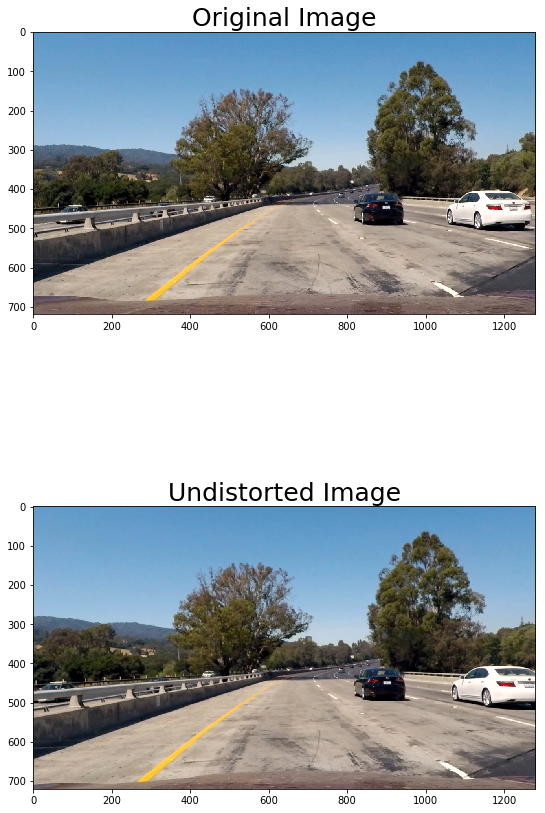

In [99]:
test_img = '../test_images/test1.jpg'
undistort_src = mpimg.imread(test_img)
undistort_dst = cv2.undistort(undistort_src, cameraMatrix, distCoeffs, None, cameraMatrix)
f, (ax1, ax2) = plt.subplots(2, 1, figsize = (9, 16))
ax1.imshow(undistort_src)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(undistort_dst)
ax2.set_title('Undistorted Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.8, bottom=0.)
plt.savefig('undistortion_test1_before_after.png')

## Creating thresholded binary image

In [88]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh = (0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        deriv = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        deriv = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    deriv = np.abs(deriv)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    deriv = np.uint8(255 * deriv / np.max(deriv))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(deriv)
    binary_output[(deriv >= thresh[0]) & (deriv <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_sobel_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    # 2) Take the gradient in x and y separately
    dx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    dy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_dx = np.abs(dx)
    abs_dy = np.abs(dy)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direc = np.arctan2(abs_dy, abs_dx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(direc)
    binary_output[(direc > thresh[0]) & (direc < thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    # binary_output = np.copy(img) # Remove this line
    return binary_output
    

# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_sobel_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    # 2) Take the gradient in x and y separately
    dx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    dy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Calculate the magnitude 
    dxy = np.sqrt(dx**2 + dy**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    dxy = np.uint8(255 * dxy / np.max(dxy))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(dxy)
    binary_output[(dxy > mag_thresh[0]) & (dxy < mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

# Color thresholding, with both x gradient and color thresholding
def pipeline(img, x_thresh = (0, 255), y_thresh = (0, 255), mag_thresh = (0, 255), dir_thresh=(0.0, np.pi/2), color_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
#     threshold gradients using l channel
    sobelx = abs_sobel_thresh(l_channel, orient='x', sobel_kernel=3, thresh = x_thresh) # Take the derivative in x
    sobely = abs_sobel_thresh(l_channel, orient='y', sobel_kernel=3, thresh = y_thresh) # Take the derivative in x
    sobel_mag = mag_sobel_thresh(l_channel, sobel_kernel=3, mag_thresh = mag_thresh)
    sobel_dir = dir_sobel_threshold(l_channel, sobel_kernel=3, thresh = dir_thresh)
                              
    sobel = np.zeros_like(l_channel)
    sobel[((sobelx == 1) & (sobely == 1)) | ((sobel_mag == 1) & (sobel_dir == 1))] = 1
#     threshold color channel
    satur = np.zeros_like(s_channel)
    satur[(s_channel >= color_thresh[0]) & (s_channel <= color_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    gray_binary = np.zeros_like(sobel)
    gray_binary[(sobel == 1) | (satur == 1)] = 1
    color_binary = np.dstack(( np.zeros_like(sobel), sobel, satur))
    return color_binary, gray_binary

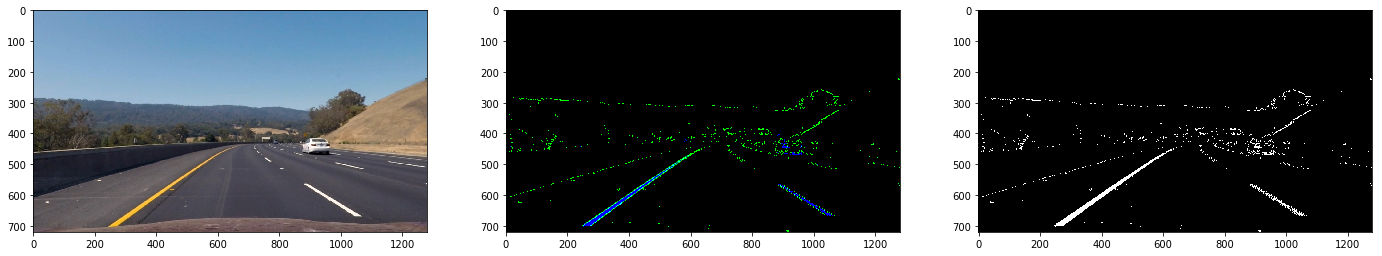

In [91]:
image = mpimg.imread('../test_images/test3.jpg')
image = cv2.undistort(image, cameraMatrix, distCoeffs, None, cameraMatrix)
color, gray = pipeline(image, x_thresh = (20, 100), y_thresh = (20, 100), mag_thresh = (50, 100), dir_thresh=(0.7, 1.3), color_thresh=(160, 255))
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (24,8))
ax1.imshow(image)
ax2.imshow(color)
ax3.imshow(gray, cmap = 'gray')